# HW 2 - Starter Code

First, be sure the sqlite file (found here: https://github.com/jknecht/baseball-archive-sqlite/raw/master/lahman2014.sqlite) is in the same folder as your code. 

The database contains many tables / relations, but we will be mainly using 2 relations: Salaries and Teams. The schema (description of the fields in the tables) are given below. Not all columns/fields are relevant for this homework, and we will pointout relevant fields as we walk through the assignement. 

Salaries table
---------------
- yearID         Year
- teamID         Team
- lgID           League
- playerID       Player ID code
- salary         Salary


Teams Table
-----------
- yearID         Year
- lgID           League
- teamID         Team
- franchID       Franchise (links to TeamsFranchise table)
- divID          Team's division
- Rank           Position in final standings
- G              Games played
- GHome          Games played at home
- W              Wins
- L              Losses
- DivWin         Division Winner (Y or N)
- WCWin          Wild Card Winner (Y or N)
- LgWin          League Champion(Y or N)
- WSWin          World Series Winner (Y or N)
- R              Runs scored
- AB             At bats
- H              Hits by batters
- 2B             Doubles
- 3B             Triples
- HR             Homeruns by batters
- BB             Walks by batters
- SO             Strikeouts by batters
- SB             Stolen bases
- CS             Caught stealing
- HBP            Batters hit by pitch
- SF             Sacrifice flies
- RA             Opponents runs scored
- ER             Earned runs allowed
- ERA            Earned run average
- CG             Complete games
- SHO            Shutouts
- SV             Saves
- IPOuts         Outs Pitched (innings pitched x 3)
- HA             Hits allowed
- HRA            Homeruns allowed
- BBA            Walks allowed
- SOA            Strikeouts by pitchers
- E              Errors
- DP             Double Plays
- FP             Fielding  percentage
- name           Team's full name
- park           Name of team's home ballpark
- attendance     Home attendance total
- BPF            Three-year park factor for batters
- PPF            Three-year park factor for pitchers
- teamIDBR       Team ID used by Baseball Reference website
- teamIDlahman45 Team ID used in Lahman database version 4.5
- teamIDretro    Team ID used by Retrosheet

In [1]:
import sqlite3
import pandas

sqlite_file = 'lahman2014.sqlite'
conn = sqlite3.connect(sqlite_file)  # connect to database and ingest the tables 

# lets run a query to look at the data
salary_query = "SELECT yearID, sum(salary) as total_payroll FROM Salaries WHERE lgID == 'AL' GROUP BY yearID"

team_salaries = pandas.read_sql(salary_query, conn)
team_salaries.head()

,yearID,total_payroll
0,1985,134401120.0
1,1986,157716444.0
2,1987,136088747.0
3,1988,157049812.0
4,1989,188771688.0


## Analysis

We want to understand how efficient teams have been historically at spending money and getting wins in return. In the case of Moneyball, one would expect that Oakland was not much more efficient than other teams in their spending before 2000, were much more efficient (they made a movie about it after all) between 2000 and 2005, and by then other teams may have caught up. Let's see how this is reflected in the data we have.

### Relation Creation

Using SQL compute a new relation that contains a subset of fields of interest to help us compute further statisitcs of interest.  We neeed to think about the type of join used as it determines how missing data is handled. In the code below, a SQL statment is executed to create the new relation jusing a join between the two tables; 




In [2]:
createTable_query = "CREATE TABLE statsTbl AS SELECT \
Salaries.yearID, Teams.teamID, Teams.name, Salaries.salary, Teams.G, Teams.W, Teams.L \
FROM Salaries  \
JOIN Teams \
ON Salaries.yearID=Teams.yearID AND Salaries.teamID=Teams.teamID \
WHERE Salaries.lgID=='AL' ;"

cursor = conn.cursor()
cursor.execute(createTable_query)
conn.commit()

# if you run this mulitple times, you may see an error stating "statsTbl already exists". This error message can be ignored. 

OperationalError: table statsTbl already exists

In [3]:
query = "select * from statsTbl;"

result = pandas.read_sql(query, conn)
result.head()


# As you can see, it generates a new table/relation which contains 7 fields:
# yearID
# teamID
# name
# salary
# G --> denotes the number of games
# W --> denotes the number of wins
# L --> denotes the number of losses

,yearID,teamID,name,salary,G,W,L,WinPCT,WinningPct
0,1985,BAL,Baltimore Orioles,625000.0,161,83,78,None,None
1,1985,BAL,Baltimore Orioles,480000.0,161,83,78,None,None
2,1985,BAL,Baltimore Orioles,437500.0,161,83,78,None,None
3,1985,BAL,Baltimore Orioles,512500.0,161,83,78,None,None
4,1985,BAL,Baltimore Orioles,375000.0,161,83,78,None,None


Suppose we want to print the rows / entries for Oakland between 1988 - 1989. Hint: need to use a WHERE clause in the SQL query to filter out rows only for teamID="OAK"

In [4]:
query = "SELECT * FROM statsTbl WHERE teamID='OAK' AND yearID>=1988 AND yearID<=1989;"

result = pandas.read_sql(query, conn)
result.head()

,yearID,teamID,name,salary,G,W,L,WinPCT,WinningPct
0,1988,OAK,Oakland Athletics,495000.0,162,104,58,None,None
1,1988,OAK,Oakland Athletics,325000.0,162,104,58,None,None
2,1988,OAK,Oakland Athletics,550000.0,162,104,58,None,None
3,1988,OAK,Oakland Athletics,650000.0,162,104,58,None,None
4,1988,OAK,Oakland Athletics,100000.0,162,104,58,None,None


Suppose we want to print the year for which Oakland had the largest number of wins. Lets write that SQL query. 

In [5]:
query = "SELECT yearID, max(W) from statsTbl WHERE teamID='OAK';"

result = pandas.read_sql(query, conn)
result.head()

,yearID,max(W)
0,1988,104


Suppose we want to compute the total payroll for teamID='OAK' for the yearID='1988'. To do this, we must sum-up all the salaries for a given team for a given year. 

In [6]:
query = "SELECT teamID, yearID, SUM(salary) AS TotalSalary  \
FROM statsTbl  \
WHERE yearID='1988' AND teamID='OAK' \
GROUP BY teamID,yearID;"

result = pandas.read_sql(query, conn)
result.head()


,teamID,yearID,TotalSalary
0,OAK,1988,9690000.0


## Problem 1 

Using SQL, compute the result containing the total payroll and winning percentage (number of wins / number of games * 100) for each team (that is, for each teamID and yearID combination). 

Hint: Be sure to perform a groupby on the fields teamID and yearID



In [7]:
query = "SELECT teamID, YearID, CAST (W AS Float)/G*100 AS WinPct, SUM(salary) AS TotalSalary \
FROM statsTbl  \
GROUP BY teamID, yearID;"

result = pandas.read_sql(query, conn)
result.head()


,teamID,yearID,WinPct,TotalSalary
0,ANA,1997,51.851852,31135472.0
1,ANA,1998,52.469136,41281000.0
2,ANA,1999,43.209877,55388166.0
3,ANA,2000,50.617284,51464167.0
4,ANA,2001,46.296296,47535167.0


## Problem 2

Write code to print out the teamID that had the highest WinningPercentage over total sepending (salaries). 

In [8]:
query = "CREATE TABLE mymetricsTbl AS SELECT teamID, CAST (W AS Float)/G*100 AS WinPct, SUM(salary) AS TotalSalary, \
CAST (W AS Float)/G/SUM(salary) AS WinsPerDollar \
FROM statsTbl  \
GROUP BY teamID, yearID;"

cursor = conn.cursor()
cursor.execute(query)
conn.commit()


OperationalError: table mymetricsTbl already exists

In [9]:
query = "SELECT * from mymetricsTbl;"
result = pandas.read_sql(query, conn)
print ("Validate Data:\n", result.head(), "\n")

query = "SELECT teamID, MAX(WinPct/TotalSalary) AS WinsPerDollar FROM metricsTbl"
result = pandas.read_sql(query, conn)
print ("Team with highest WinPct/$: \n", result.head())

Validate Data:
   teamID     WinPct  TotalSalary  WinsPerDollar
0    ANA  51.851852   31135472.0   1.665363e-08
1    ANA  52.469136   41281000.0   1.271024e-08
2    ANA  43.209877   55388166.0   7.801283e-09
3    ANA  50.617284   51464167.0   9.835442e-09
4    ANA  46.296296   47535167.0   9.739378e-09 

Team with highest WinPct/$: 
   teamID  WinsPerDollar
0    HOU   8.151730e-07


## Problem 3

Write code to produce plots that illustrate the team's total spending (salaries) conditioned on time (from 1990-2014), specifically for teamID='OAK'.

In [10]:
def remove_border(axes=None, top=False, right=False, 
                  left=True, bottom=True):
    #credit: Professor Salloum
    """
    Minimize chartjunk by stripping out unnecesasry plot
    borders and axis ticks
    
    The top/right/left/bottom keywords toggle whether the 
    corresponding plot border is drawn
    """
    ax = axes or plt.gca()
    ax.spines['top'].set_visible(top)
    ax.spines['right'].set_visible(right)
    ax.spines['left'].set_visible(left)
    ax.spines['bottom'].set_visible(bottom)
    
    #turn off all ticks
    ax.yaxis.set_ticks_position('none')
    ax.xaxis.set_ticks_position('none')
    
    #now re-enable visibles
    if top:
        ax.xaxis.tick_top()
    if bottom:
        ax.xaxis.tick_bottom()
    if left:
        ax.yaxis.tick_left()
    if right:
        ax.yaxis.tick_right()

Data Validation:
   teamID  yearID  TotalSalary
0    OAK    1990   19887501.0
1    OAK    1991   36999167.0
2    OAK    1992   41035000.0
3    OAK    1993   37812333.0
4    OAK    1994   34172500.0


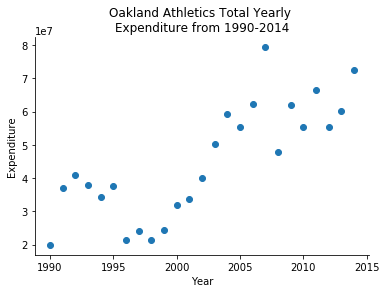

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

query = "SELECT teamID, yearID, SUM(salary) AS TotalSalary  \
FROM statsTbl  \
WHERE yearID>='1990' AND yearID <=2014 AND teamID='OAK' \
GROUP BY teamID,yearID;"

result = pandas.read_sql(query, conn)
print ("Data Validation:\n", result.head())

plt.scatter(result["yearID"], result["TotalSalary"])
plt.xlabel("Year")
plt.ylabel("Expenditure")
plt.title("Oakland Athletics Total Yearly \nExpenditure from 1990-2014")
remove_border()
plt.show()

## Problem 4

Write code to discretize year into five time periods (you can use pandas.cut to accomplish this) and then make a scatterplot showing mean winning percentage (y-axis) vs. mean payroll (x-axis) for each of the five time periods.

What can you say about team payrolls across these periods? Are there any teams that standout as being particularly good at paying for wins across these time periods? What can you say about the Oakland A’s spending efficiency across these time periods (labeling points in the scatterplot can help interpretation).

In [124]:
#Create Scatterplot x-axis
query = "SELECT yearID FROM statsTbl GROUP BY yearID;"

result = pandas.read_sql(query, conn)
print ("Validate Data:\n", result.head(10))
print ("\n")

#bin the data
t = pandas.cut(result["yearID"], 5, retbins = True)

t = [round(i, 0) for i in t[1]]
t = t[:-1]
print ("rounded t:", t)

Validate Data:
    yearID
0    1985
1    1986
2    1987
3    1988
4    1989
5    1990
6    1991
7    1992
8    1993
9    1994


rounded t: [1985.0, 1991.0, 1997.0, 2002.0, 2008.0]


In [13]:
#Create table of WinPct and Expenditure
query = "CREATE TABLE table3 AS SELECT teamID, yearID, CAST (W AS Float)/G*100 AS WinPct, SUM(salary) AS TotalSalary \
FROM statsTbl GROUP BY teamID, yearID;"

cursor = conn.cursor()
cursor.execute(query)
conn.commit()


OperationalError: table table3 already exists

In [14]:
query = "SELECT * from table3;"
result = pandas.read_sql(query, conn)
result.head()

,teamID,yearID,WinPct,TotalSalary
0,ANA,1997,51.851852,31135472.0
1,ANA,1998,52.469136,41281000.0
2,ANA,1999,43.209877,55388166.0
3,ANA,2000,50.617284,51464167.0
4,ANA,2001,46.296296,47535167.0


In [311]:
query = "SELECT * from table3;"
result = pandas.read_sql(query, conn)

d = {}
for i in range(len(t)-1):
    d[i] = "SELECT teamID, yearID AS RangeMin, AVG(WinPct) AS AvgWinPct, TotalSalary FROM table3 WHERE yearID >= %d AND yearID < %d GROUP BY teamID;" % (t[i], t[i+1])
    d[i] = pandas.read_sql(d[i], conn)

d2 = {}
for group in d:
    teamList = d[group]["teamID"]
    winPPY = d[group]["AvgWinPct"]
    for teamIndex in range(len(teamList)):
        team = teamList[teamIndex]
        teamWPPY = winPPY[teamIndex]
        if team not in d2:
            d2[team] = [[t[group], teamWPPY]]
        else:
            d2[team] += [[t[group], teamWPPY]]

d3 = {}
for i in range(len(t)-1):
    d[i] = "SELECT teamID, yearID AS RangeMin, AVG(TotalSalary) AS ATS FROM table3 WHERE yearID >= %d AND yearID < %d GROUP BY teamID;" % (t[i], t[i+1])
    d[i] = pandas.read_sql(d[i], conn)

d4 = {}
for group in d:
    teamList = d[group]["teamID"]
    winPPY = d[group]["ATS"]
    for teamIndex in range(len(teamList)):
        team = teamList[teamIndex]
        teamWPPY = winPPY[teamIndex]
        if team not in d2:
            d2[team] = [[t[group], teamWPPY]]
        else:
            d2[team] += [[t[group], teamWPPY]]

            
#List of lengths
lengs = [[key, len(d2[key])] for key in d2.keys()]

d4

{}

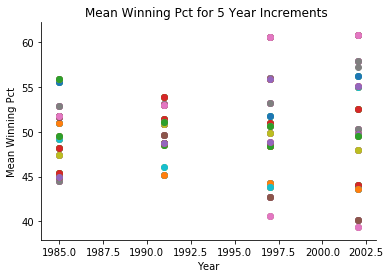

In [301]:
for team in range(len(d2)):
# for team in range(6):
    teamName = lengs[team][0]
#     print (teamName)
    for i in range(len(d2[teamName])):
#         print (d2[teamName][i][0], ",", d2[teamName][i][1])
#         plt.plot(d2[teamName] [i][0], d2[teamName] [i][1])
        plt.scatter([d2[teamName][i][0] for i in range(len(d2[teamName]))], \
                 [d2[teamName][i][1] for i in range(len(d2[teamName]))])


plt.xlabel("Year")
plt.ylabel("Mean Winning Pct")
plt.title("Mean Winning Pct for 5 Year Increments ")
remove_border()
plt.show()
# plt.plot([d2["ANA"][i][0] for i in range(len(d2["ANA"]))], [d2["ANA"][i][1] for i in range(len(d2["ANA"]))])


What can you say about team payrolls across these periods? Are there any teams that standout as being particularly good at paying for wins across these time periods? What can you say about the Oakland A’s spending efficiency across these time periods (labeling points in the scatterplot can help interpretation).

I unfortunately answered the wrong question - I looked at average winning pct over the years. I spent about 9 hours coding this. 